In [23]:
# !pip install kaggle
# !pip install tpot
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset
# ! unzip /content/face-expression-recognition-dataset.zip

In [1]:
import glob
import os
import tensorflow as tf 
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from PIL import Image
from keras.preprocessing.image import load_img, img_to_array



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data_path = "/content/images"
Train_path = os.path.join(data_path,'train')
Valid_path = os.path.join(data_path,'validation')
Train_data = []
Valid_data = []
for subdir, dirs, files in os.walk(Train_path):
  for filename in files:
    filepath = subdir + os.sep + filename
    Train_data.append((filename,os.path.split(subdir)[1]))

for subdir ,dirs ,files in os.walk(Valid_path):
  for filename in files : 
    Valid_data.append((filename,os.path.split(subdir)[1]))

print("training files : ",len(Train_data))
print("Validation files: ",len(Valid_data))

training files :  28821
Validation files:  7066


In [3]:
df  = pd.DataFrame(columns=['filename','label'])
df['filename']= [data[0] for data in Train_data]
df['label'] = [data[1] for data in Train_data]
df.head()

,filename,label
0,11364.jpg,surprise
1,21443.jpg,surprise
2,20018.jpg,surprise
3,17619.jpg,surprise
4,28902.jpg,surprise


In [4]:
df["label"].value_counts()

happy       7164
neutral     4982
sad         4938
fear        4103
angry       3993
surprise    3205
disgust      436
Name: label, dtype: int64

In [5]:
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
df["label_code"] = lb_make.fit_transform(df["label"])

In [6]:
df.groupby(['label_code']).count()['label']

label_code
0    3993
1     436
2    4103
3    7164
4    4982
5    4938
6    3205
Name: label, dtype: int64

In [7]:
idx = np.random.randint(len(df), size=1)[0]
flname , label = Train_data[0]
img = Image.open(os.path.join(Train_path,os.path.join(label,flname)))

IMG_SHAPE = [128,128]
WIDTH =IMG_SHAPE[0]
HEIGHT = IMG_SHAPE[1]

print ("image shape {} x{}".format(WIDTH,HEIGHT))

image shape 128 x128


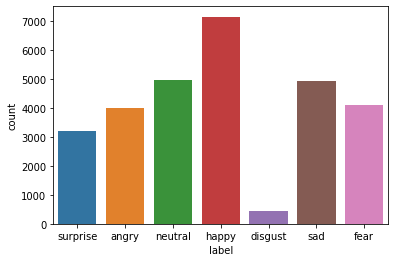

In [8]:
sns.countplot(x=df.label)
# so we see the datset for the disgust is least 

In [9]:
def plot_image_examples(df, rows=3, cols=3, title='Image examples'):
  fig, axs = plt.subplots(rows, cols, figsize=(10,10))
  for row in range(rows):
        for col in range(cols):
            idx = np.random.randint(len(df), size=1)[0]
            filename,label  = Train_data[idx]
            img_file = os.path.join(Train_path,os.path.join(label,filename))
            img = load_img(img_file,target_size=(WIDTH,HEIGHT))
            axs[row, col].imshow(img)
            axs[row,col].set_title(label)

            
  plt.suptitle(title)
            

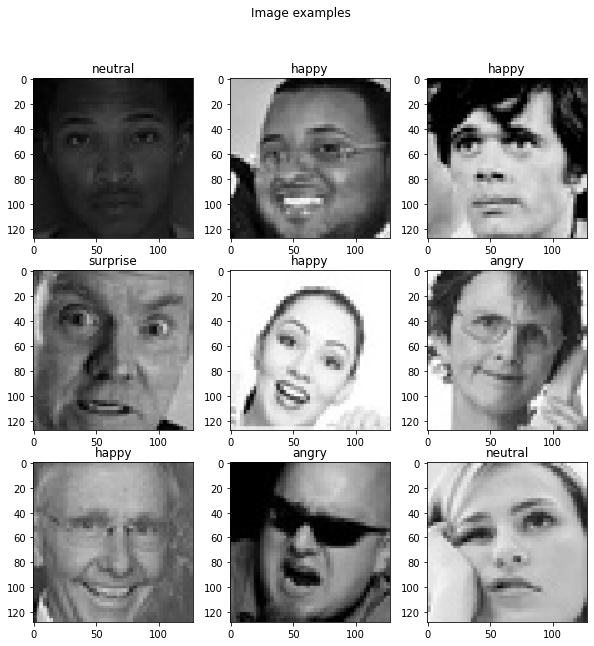

In [10]:
plot_image_examples(df)

In [11]:
import dlib
from imutils.face_utils import FaceAligner

In [12]:
from keras.preprocessing.image import ImageDataGenerator
# number of images to feed into the NN for every batch
batch_size = 128
datagen_training = ImageDataGenerator()
datagen_validation = ImageDataGenerator()

train_generator = datagen_training.flow_from_directory(Train_path,
                                                    target_size=(WIDTH,HEIGHT),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,                                                
                                                    class_mode='categorical',
                                                    shuffle=True)

valid_generator = datagen_validation.flow_from_directory(Valid_path,target_size=(WIDTH,HEIGHT),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,

                                                    class_mode='categorical')
nb_classes = train_generator.num_classes

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [13]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
data = []
labels = []

def decode_img(img,shape=(256,256),channel = 3):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=1)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float16)
  # resize the image to the desired size.
  img = tf.image.resize(img,[shape[0],shape[1]])
  return img

for imgpath ,label in Train_data:
  image_path =  os.path.join(Train_path,os.path.join(label,imgpath))
  label = lb_make.transform([label])
  
  img = tf.io.read_file(image_path)
  img = decode_img(img,shape=(96,96),channel =1 )
  
  data.append(img.numpy())
  labels.append(label)

labels = np.asarray(labels)
data = np.asarray(data)
print(data.shape)
print(labels.shape)


datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    vertical_flip=True)
datagen.fit(data)

labels_embedding = to_categorical(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels_embedding,test_size=0.25, stratify=labels, random_state=42)
print(trainX.shape)
print(trainY.shape)
print (testX.shape)
print (testY.shape)

(28821, 96, 96, 1)
(28821, 1)
(21615, 96, 96, 1)
(21615, 7)
(7206, 96, 96, 1)
(7206, 7)


In [14]:
import gc 
gc.collect()

18885

In [15]:
# Since we have used Image Datagenrator , we do not need to use this read and decode code - we can skip it 

In [16]:
from tensorflow.keras.applications import MobileNetV2,ResNet50
from tensorflow.keras.layers import Input 
from tensorflow.keras.models import Model ,Sequential
from tensorflow.keras.layers import Conv2D , Dropout,BatchNormalization,Dense,Flatten,Dropout
from tensorflow.keras.optimizers import Adam,SGD
base_model = ResNet50(
    input_shape=(IMG_SHAPE[0],IMG_SHAPE[1],3),
    include_top=False,
    weights='imagenet')

for layers in base_model.layers[:100]:
  layers.trainable=False

# Define Hyperparameters 
opt = Adam(lr=0.01)

BATCH_SIZE = 32
BUFFER = 1000
INIT_LR = 0.01
EPOCHS = 10

In [17]:
# Since we can not use the grayscale image with MObilenet model , will need to 
# add a input layer of kernel size 3,3
model  = Sequential()
input_layer = tf.keras.layers.Conv2D(3,(3,3),padding='same',activation='relu',input_shape=(IMG_SHAPE[0],IMG_SHAPE[1],1))
model.add(input_layer)
model.add(base_model)

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(nb_classes, activation='softmax'))


In [18]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [19]:
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 3)       30        
_________________________________________________________________
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               16777728  
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 3

In [20]:
# Fitting the model 
H = model.fit(train_generator,
              epochs=EPOCHS,
              callbacks=callbacks_list,
              validation_data=valid_generator,
              )

Epoch 1/10
226/226 [==============================] - ETA: 0s - loss: 1.5850 - accuracy: 0.4518
Epoch 00001: val_accuracy improved from -inf to 0.28856, saving model to model_weights.h5
226/226 [==============================] - 95s 419ms/step - loss: 1.5850 - accuracy: 0.4518 - val_loss: 508.2811 - val_accuracy: 0.2886
Epoch 2/10
226/226 [==============================] - ETA: 0s - loss: 1.2187 - accuracy: 0.5459
Epoch 00002: val_accuracy improved from 0.28856 to 0.51415, saving model to model_weights.h5
226/226 [==============================] - 93s 413ms/step - loss: 1.2187 - accuracy: 0.5459 - val_loss: 1.3124 - val_accuracy: 0.5142
Epoch 3/10
226/226 [==============================] - ETA: 0s - loss: 1.3372 - accuracy: 0.5391
Epoch 00003: val_accuracy did not improve from 0.51415
226/226 [==============================] - 92s 408ms/step - loss: 1.3372 - accuracy: 0.5391 - val_loss: 83.8432 - val_accuracy: 0.1642
Epoch 4/10
226/226 [==============================] - ETA: 0s - loss:

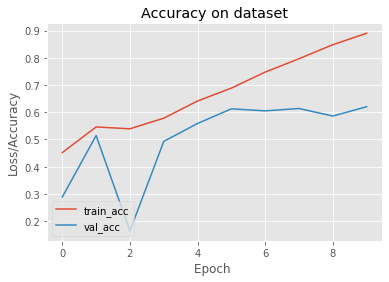

In [21]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Accuracy on dataset")
plt.xlabel("Epoch ")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

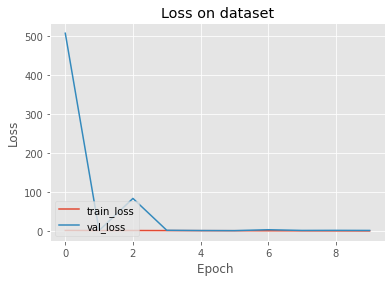

In [22]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Loss on dataset")
plt.xlabel("Epoch ")
plt.ylabel("Loss")
plt.legend(loc="lower left")

In [29]:
from keras.models import load_model
saved_model = load_model('/content/model_weights.h5')


In [30]:
class_names = valid_generator.class_indices
print (class_names)
rev_dict = {}
rev_dict = {v: k for k, v in class_names.items()}
print (rev_dict)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [34]:
predictions = saved_model.predict_generator(generator=valid_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = valid_generator.classes

pred_df  = pd.DataFrame(columns=['Target_label','Pred_label'])
pred_df['Target_idx']= y_test
pred_df['Pred_idx'] = y_pred
pred_df['Target_label'] = [rev_dict[i] for i in y_test]
pred_df['Pred_label'] = [rev_dict[i] for i in y_pred]

In [32]:
from sklearn.metrics import confusion_matrix , accuracy_score
import itertools
print (accuracy_score(y_test,y_pred))

0.17095952448344184


<Figure size 432x288 with 0 Axes>

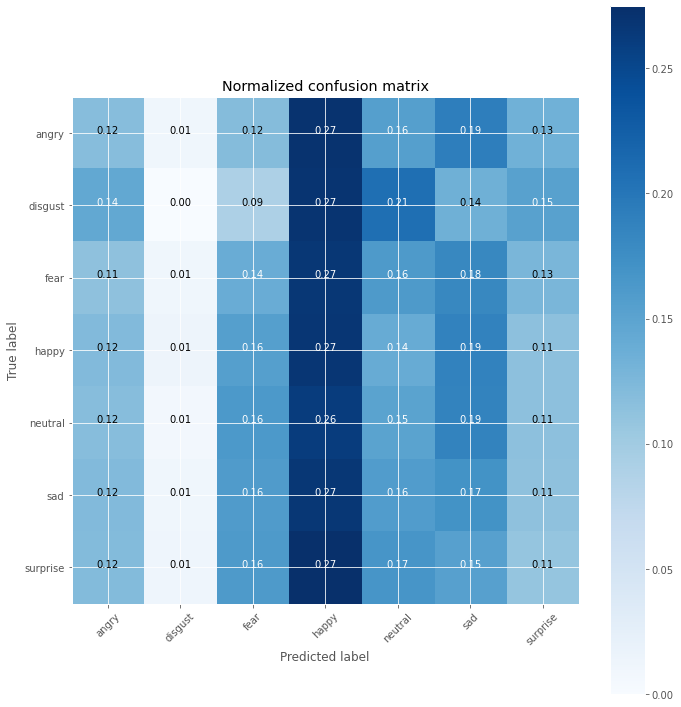

In [33]:

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

In [28]:
# Bag of Feature Approach - use 128 dimensional vectors 

In [35]:
model_fetext  = Sequential()
input_layer = tf.keras.layers.Conv2D(3,(3,3),padding='same',activation='relu',input_shape=(IMG_SHAPE[0],IMG_SHAPE[1],1))
model_fetext.add(input_layer)
model_fetext.add(base_model)
model_fetext.add(Dense(128,activation='linear'))
model_fetext.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
model_fetext.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 3)       30        
_________________________________________________________________
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
dense_2 (Dense)              (None, 4, 4, 128)         262272    
Total params: 23,850,014
Trainable params: 19,715,230
Non-trainable params: 4,134,784
_________________________________________________________________


In [36]:
features  = model_fetext.predict(train_generator,batch_size=BATCH_SIZE)
features = features.reshape(features.shape[0],4*4*128)
labels = train_generator.classes

In [38]:
print (features.shape)
print(labels.shape)

(28821, 2048)
(28821,)


In [40]:
from sklearn.model_selection import train_test_split
(trainX, testX, trainY, testY) = train_test_split(features, labels,test_size=0.35, stratify=labels, random_state=42)
print (trainX.shape)
print (trainY.shape)
print (testX.shape)
print (testY.shape)

(18733, 2048)
(18733,)
(10088, 2048)
(10088,)


In [41]:
gc.collect()

0

In [43]:
#Import svm model
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV 
clf = SVC(kernel='rbf',C=10,gamma=0.01) # RBF Kernel
clf.fit(trainX[:500],trainY[:500])

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [44]:
from sklearn.metrics import confusion_matrix,accuracy_score ,classification_report,roc_curve,auc
predictions_rbf = clf.predict(testX[:500])
print (accuracy_score(y_true=testY[:500],y_pred=predictions_rbf)*100.0)
print (classification_report(y_true=testY[:500],y_pred=predictions_rbf))

18.0
              precision    recall  f1-score   support

           0       0.14      0.11      0.12        63
           1       0.00      0.00      0.00        12
           2       0.07      0.04      0.05        70
           3       0.25      0.44      0.32       121
           4       0.10      0.10      0.10        92
           5       0.18      0.16      0.17        98
           6       0.11      0.05      0.06        44

    accuracy                           0.18       500
   macro avg       0.12      0.13      0.12       500
weighted avg       0.15      0.18      0.16       500

